In [ ]:
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Data Access

## servers everywhere and not a bit to flip

![](https://imgs.xkcd.com/comics/digital_data.png)

# whoami

`ocefpaf` (Filipe Fernandes)

- Physical Oceanographer
- Data Plumber
- Code Janitor
- CI babysitter
- Amazon-Dash-Button for conda-forge

# My day job: IOOS


![](https://raw.githubusercontent.com/ocefpaf/2018-SciPy-talk/gh-pages/images/IOOS-RAs.jpg)

# Big or small we need data!

## There are various sources, servers, APIs, and web services: OPeNDAP, ERDDAP, THREDDS, ftp, http(s), S3, LAS, etc.

![](https://imgs.xkcd.com/comics/data_pipeline.png)

# Web Services

| Data Type                              | Web Service                       | Response    |
|----------------------------------------|-----------------------------------|-------------|
| In-situ data<br>(buoys, stations, etc) | OGC SOS                           | XML/CSV     |
| Gridded data (models, satellite)       | OPeNDAP                           | Binary      |
| Raster Images                          | OGC WMS                           | GeoTIFF/PNG |
| ERDDAP                                 | Restful API                       | *           |

* You imagination is the limit!

# How does this all work?
## Standards!

![](https://imgs.xkcd.com/comics/standards.png)

# What are we going to see in this tutorial?
## Browse and access data from:

1. ERDDAP
2. OPeNDAP
3. SOS
4. WMS

# 1) Exploring the OOI ERDDAP server

### Learning objectives:

- Explorer an ERDDAP server with the python interface (erddapy);
- Find a glider for a time/region of interest;
- Download the data with a familiar format and create some plots.

## What is ERDDAP?

- Flexible outputs: `.html` table, ESRI `.asc` and `.csv`, Google Earth `.kml`, OPeNDAP binary, `.mat`, `.nc`, ODV `.txt`, `.csv`, `.tsv`, `.json`, and `.xhtml`
- Free RESTful API to access the data
- Standardize dates and time in the results
- Server-side searching and slicing

In [ ]:
from erddapy import ERDDAP


server = "https://erddap-uncabled.oceanobservatories.org/uncabled/erddap"
e = ERDDAP(server=server)

### What services are available in the **erddap-uncabled.oceanobservatories** server?

In [ ]:
import pandas as pd


df = pd.read_csv(
    e.get_search_url(response="csv", search_for="all")
)

In [ ]:
print(
    f'We have {len(set(df["tabledap"].dropna()))} '
    f'tabledap, {len(set(df["griddap"].dropna()))} '
    f'griddap, and {len(set(df["wms"].dropna()))} wms endpoints.'
)

### Let's query all the datasets that have the "trajectory" CDM data type.

In [ ]:
url = e.get_categorize_url(
    categorize_by="cdm_data_type",
    value="trajectory",
    response="csv",
)

df = pd.read_csv(url)
dataset_ids = df.loc[~df['tabledap'].isnull(), 'Dataset ID'].tolist()

dataset_ids_list = "\n".join(dataset_ids)
print(f"Found {len(dataset_ids)} datasets")

### Let us narrow our search to deployments that have *salinity* data within a lon/lat/time extent.

In [ ]:
from ipyleaflet import Map, Rectangle


min_lon, max_lon = -136, -120
min_lat, max_lat = 41.78, 52.24

rectangle = Rectangle(bounds=((min_lat, min_lon), (max_lat, max_lon)))

m = Map(center=((min_lat+max_lat)/2, (min_lon+max_lon)/2), zoom=4)
m.add_layer(rectangle)
m

In [ ]:
kw = {
    "min_time": "2017-01-01T00:00:00Z",
    "min_time": "2019-08-31T00:00:00Z",
    "min_lon": min_lon,
    "max_lon": max_lon,
    "min_lat": min_lat,
    "max_lat": max_lat,
    "standard_name": "sea_water_practical_salinity",
    "cdm_data_type": "trajectory",
}

In [ ]:
search_url = e.get_search_url(response="csv", **kw)
search = pd.read_csv(search_url)
dataset_ids = search["Dataset ID"].values

dataset_ids_list = "\n".join(dataset_ids)
print(f"Found {len(dataset_ids)} Datasets:\n{dataset_ids_list}")

In [ ]:
e.dataset_id = dataset_ids[0]
e.protocol = "tabledap"

e.variables = [
    "sci_water_pressure_dbar",
    "latitude",
    "longitude",
    "practical_salinity",
    "sci_water_temp",
    "time",
]

url = e.get_download_url()
print(url)

In [ ]:
import pandas as pd


df = e.to_pandas(
    index_col="time (UTC)",
    parse_dates=True,
).dropna()

df.head()

Exercise: experiment with the `e.to_xarray()` method. Think about why/where use one or the other?

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


dx, dy = 2, 4
x = df["longitude (degrees_east)"]
y = df["latitude (degrees_north)"]
dx, dy = 2, 4

fig, ax = plt.subplots(figsize=(5, 5),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
cs = ax.scatter(x, y, c=df[r"sci_water_temp (\u00baC)"],
                s=50, alpha=0.5, edgecolor="none")
cbar = fig.colorbar(cs, orientation="vertical",
                    fraction=0.1, shrink=0.9, extend="both")
ax.coastlines("10m")
ax.set_extent([x.min()-dx, x.max()+dx, y.min()-dy, y.max()+dy]);

In [ ]:
import matplotlib.dates as mdates
    
fig, ax = plt.subplots(figsize=(17, 5))
cs = ax.scatter(df.index, df["sci_water_pressure_dbar (dbar)"],
                s=15, c=df[r"sci_water_temp (\u00baC)"],
                marker="o", edgecolor="none",)

ax.invert_yaxis()
xfmt = mdates.DateFormatter("%H:%Mh\n%d-%b")
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation="vertical", extend="both")
cbar.ax.set_ylabel("Temperature ($^\circ$C)")
ax.set_ylabel("Pressure ((dbar))");

In [ ]:
import gsw
import numpy as np

s = np.linspace(0, 42, 100)
t = np.linspace(-2, 40, 100)

s, t = np.meshgrid(s, t)

sigma = gsw.sigma0(s, t)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

cnt = np.arange(-7, 40, 5)
cs = ax.contour(s, t, sigma, colors="gray", levels=cnt)
ax.clabel(cs, fontsize=9, inline=1, fmt="%2i")

ax.set_xlabel("Salinity [g kg$^{-1}$]")
ax.set_ylabel("Temperature [$^{\circ}$C]")
ax.scatter(df[r"sci_water_temp (\u00baC)"],
           df["practical_salinity (1)"],
           s=10, alpha=0.5)

ax.grid(True)
ax.axis([5, 20, 28, 37.5]);

Exercise: explore the web interface for the OOI server URL:

https://erddap-uncabled.oceanobservatories.org/uncabled/erddap

or the IOOS glider dac:

https://gliders.ioos.us/erddap

and find a dataset of interested, download a format that you are familiar with and plot it (using the web interface or the Python, your choice).

# 2) IOOS OPeNDAP via an ERDDAP server

### Learning objectives:

- Open a dataset from an ERDDAP server using the OPeNDAP response;
- Compare with an `erddapy` request;
- Plot it using `xarray` interface.

In [1]:
import xarray as xr


dataset_id = "pmlEsaCCI31OceanColor8Day"
url = f"https://coastwatch.pfeg.noaa.gov/erddap/griddap/{dataset_id}"

ds = xr.open_dataset(url)

In [2]:
ds

<xarray.Dataset>
Dimensions:             (latitude: 4320, longitude: 8640, time: 959)
Coordinates:
  * time                (time) datetime64[ns] 1997-09-04 ... 2018-06-26
  * latitude            (latitude) float32 89.979164 89.9375 ... -89.979164
  * longitude           (longitude) float32 -179.97917 -179.9375 ... 179.97917
Data variables:
    Rrs_412             (time, latitude, longitude) float32 ...
    Rrs_443             (time, latitude, longitude) float32 ...
    Rrs_490             (time, latitude, longitude) float32 ...
    Rrs_510             (time, latitude, longitude) float32 ...
    Rrs_555             (time, latitude, longitude) float32 ...
    Rrs_670             (time, latitude, longitude) float32 ...
    water_class1        (time, latitude, longitude) float32 ...
    water_class2        (time, latitude, longitude) float32 ...
    water_class3        (time, latitude, longitude) float32 ...
    water_class4        (time, latitude, longitude) float32 ...
    water_class5        (time, latitude, longitude) float32 ...
    water_class6        (time, latitude, longitude) float32 ...
    water_class7        (time, latitude, longitude) float32 ...
    water_class8        (time, latitude, longitude) float32 ...
    water_class9        (time, latitude, longitude) float32 ...
    water_class10       (time, latitude, longitude) float32 ...
    water_class11       (time, latitude, longitude) float32 ...
    water_class12       (time, latitude, longitude) float32 ...
    water_class13       (time, latitude, longitude) float32 ...
    water_class14       (time, latitude, longitude) float32 ...
    atot_412            (time, latitude, longitude) float32 ...
    atot_443            (time, latitude, longitude) float32 ...
    atot_490            (time, latitude, longitude) float32 ...
    atot_510            (time, latitude, longitude) float32 ...
    atot_555            (time, latitude, longitude) float32 ...
    atot_670            (time, latitude, longitude) float32 ...
    aph_412             (time, latitude, longitude) float32 ...
    aph_443             (time, latitude, longitude) float32 ...
    aph_490             (time, latitude, longitude) float32 ...
    aph_510             (time, latitude, longitude) float32 ...
    aph_555             (time, latitude, longitude) float32 ...
    aph_670             (time, latitude, longitude) float32 ...
    adg_412             (time, latitude, longitude) float32 ...
    adg_443             (time, latitude, longitude) float32 ...
    adg_490             (time, latitude, longitude) float32 ...
    adg_510             (time, latitude, longitude) float32 ...
    adg_555             (time, latitude, longitude) float32 ...
    adg_670             (time, latitude, longitude) float32 ...
    bbp_412             (time, latitude, longitude) float32 ...
    bbp_443             (time, latitude, longitude) float32 ...
    bbp_490             (time, latitude, longitude) float32 ...
    bbp_510             (time, latitude, longitude) float32 ...
    bbp_555             (time, latitude, longitude) float32 ...
    bbp_670             (time, latitude, longitude) float32 ...
    chlor_a             (time, latitude, longitude) float32 ...
    kd_490              (time, latitude, longitude) float32 ...
    Rrs_412_rmsd        (time, latitude, longitude) float32 ...
    Rrs_443_rmsd        (time, latitude, longitude) float32 ...
    Rrs_490_rmsd        (time, latitude, longitude) float32 ...
    Rrs_510_rmsd        (time, latitude, longitude) float32 ...
    Rrs_555_rmsd        (time, latitude, longitude) float32 ...
    Rrs_670_rmsd        (time, latitude, longitude) float32 ...
    Rrs_412_bias        (time, latitude, longitude) float32 ...
    Rrs_443_bias        (time, latitude, longitude) float32 ...
    Rrs_490_bias        (time, latitude, longitude) float32 ...
    Rrs_510_bias        (time, latitude, longitude) float32 ...
    Rrs_555_bias        (time, latitude, longitude) float32 ...
    Rrs_67

In [6]:
selection = ds.sel(
    time="2017-01-01",
    latitude=slice(26, 25),
    longitude=slice(-61, -60),
)

selection

<xarray.Dataset>
Dimensions:             (latitude: 24, longitude: 24)
Coordinates:
    time                datetime64[ns] 2017-01-01
  * latitude            (latitude) float32 25.979166 25.9375 ... 25.020834
  * longitude           (longitude) float32 -60.979168 -60.9375 ... -60.020832
Data variables:
    Rrs_412             (latitude, longitude) float32 ...
    Rrs_443             (latitude, longitude) float32 ...
    Rrs_490             (latitude, longitude) float32 ...
    Rrs_510             (latitude, longitude) float32 ...
    Rrs_555             (latitude, longitude) float32 ...
    Rrs_670             (latitude, longitude) float32 ...
    water_class1        (latitude, longitude) float32 ...
    water_class2        (latitude, longitude) float32 ...
    water_class3        (latitude, longitude) float32 ...
    water_class4        (latitude, longitude) float32 ...
    water_class5        (latitude, longitude) float32 ...
    water_class6        (latitude, longitude) float32 ...
    water_class7        (latitude, longitude) float32 ...
    water_class8        (latitude, longitude) float32 ...
    water_class9        (latitude, longitude) float32 ...
    water_class10       (latitude, longitude) float32 ...
    water_class11       (latitude, longitude) float32 ...
    water_class12       (latitude, longitude) float32 ...
    water_class13       (latitude, longitude) float32 ...
    water_class14       (latitude, longitude) float32 ...
    atot_412            (latitude, longitude) float32 ...
    atot_443            (latitude, longitude) float32 ...
    atot_490            (latitude, longitude) float32 ...
    atot_510            (latitude, longitude) float32 ...
    atot_555            (latitude, longitude) float32 ...
    atot_670            (latitude, longitude) float32 ...
    aph_412             (latitude, longitude) float32 ...
    aph_443             (latitude, longitude) float32 ...
    aph_490             (latitude, longitude) float32 ...
    aph_510             (latitude, longitude) float32 ...
    aph_555             (latitude, longitude) float32 ...
    aph_670             (latitude, longitude) float32 ...
    adg_412             (latitude, longitude) float32 ...
    adg_443             (latitude, longitude) float32 ...
    adg_490             (latitude, longitude) float32 ...
    adg_510             (latitude, longitude) float32 ...
    adg_555             (latitude, longitude) float32 ...
    adg_670             (latitude, longitude) float32 ...
    bbp_412             (latitude, longitude) float32 ...
    bbp_443             (latitude, longitude) float32 ...
    bbp_490             (latitude, longitude) float32 ...
    bbp_510             (latitude, longitude) float32 ...
    bbp_555             (latitude, longitude) float32 ...
    bbp_670             (latitude, longitude) float32 ...
    chlor_a             (latitude, longitude) float32 ...
    kd_490              (latitude, longitude) float32 ...
    Rrs_412_rmsd        (latitude, longitude) float32 ...
    Rrs_443_rmsd        (latitude, longitude) float32 ...
    Rrs_490_rmsd        (latitude, longitude) float32 ...
    Rrs_510_rmsd        (latitude, longitude) float32 ...
    Rrs_555_rmsd        (latitude, longitude) float32 ...
    Rrs_670_rmsd        (latitude, longitude) float32 ...
    Rrs_412_bias        (latitude, longitude) float32 ...
    Rrs_443_bias        (latitude, longitude) float32 ...
    Rrs_490_bias        (latitude, longitude) float32 ...
    Rrs_510_bias        (latitude, longitude) float32 ...
    Rrs_555_bias        (latitude, longitude) float32 ...
    Rrs_670_bias        (latitude, longitude) float32 ...
    chlor_a_log10_rmsd  (latitude, longitude) float32 ...
    chlor_a_log10_bias  (latitude, longitude) float32 ...
    aph_412_rmsd        (latitude, longitude) float32 ...
    aph_443_rmsd        (latitude, longitude) float32 ...
    aph_490_rmsd        (latitude, longitude) float32 ...
    aph_510_rmsd        (latitude, longitu

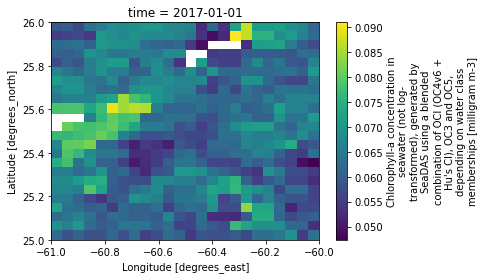

In [13]:
selection["chlor_a"].plot();

# 3) CO-OPS SOS

### Learning objectives:

- Quick explanation on the SOS API.

```python
url = (
    'https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?'
    'service=SOS'
    '&request=GetObservation'
    '&version=1.0.0'
    '&observedProperty=water_surface_height_above_reference'
    '&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8454000'
    '&responseFormat=text/csv'
    '&eventTime=2018-07-04T00:00:00Z/2018-07-05T00:00:00Z'
    '&result=VerticalDatum==urn:ogc:def:datum:epsg::5103'
    '&dataType=PreliminarySixMinute'
)
```

```python
url = (
    f'https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?'
    f'service=SOS&request={request}'
    f'&version={version}'
    f'&observedProperty={variable}'
    f'&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8454000'
    f'&responseFormat={response}'
    f'&eventTime={yesterday:%Y-%m-%dT%H:%M:%SZ}/'
    f'{today:%Y-%m-%dT%H:%M:%SZ}'
    f'&result=VerticalDatum=={vdatum}'
    f'&dataType={data_type}'
)
```

In [16]:
from datetime import datetime, timedelta

variable = 'water_surface_height_above_reference_datum'
today = datetime.today()
yesterday = today - timedelta(days=1)

buoy = '8771450'

url = (
    'https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?'
    'service=SOS'
    '&request=GetObservation'
    '&version=1.0.0'
    f'&observedProperty={variable}'
    f'&offering=urn:ioos:station:NOAA.NOS.CO-OPS:{buoy}'
    '&responseFormat=text/csv'
    f'&eventTime={yesterday:%Y-%m-%dT%H:%M:%SZ}/'
    f'{today:%Y-%m-%dT%H:%M:%SZ}'
    '&result=VerticalDatum==urn:ogc:def:datum:epsg::5103'
    '&dataType=PreliminarySixMinute'
)

print(url)

https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?service=SOS&request=GetObservation&version=1.0.0&observedProperty=water_surface_height_above_reference_datum&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8771450&responseFormat=text/csv&eventTime=2020-07-25T19:20:52Z/2020-07-26T19:20:52Z&result=VerticalDatum==urn:ogc:def:datum:epsg::5103&dataType=PreliminarySixMinute


In [17]:
import pandas as pd


df = pd.read_csv(url, index_col='date_time', parse_dates=True)

df.head()

,station_id,sensor_id,latitude (degree),longitude (degree),water_surface_height_above_reference_datum (m),datum_id,vertical_position (m),sigma,quality_flags
date_time,,,,,,,,,
2020-07-25 19:24:00+00:00,urn:ioos:station:NOAA.NOS.CO-OPS:8771450,urn:ioos:sensor:NOAA.NOS.CO-OPS:8771450:A1,29.31,-94.7933,0.904,urn:ogc:def:datum:epsg::5103,1.43,0.009,0;0;0;0
2020-07-25 19:30:00+00:00,urn:ioos:station:NOAA.NOS.CO-OPS:8771450,urn:ioos:sensor:NOAA.NOS.CO-OPS:8771450:A1,29.31,-94.7933,0.905,urn:ogc:def:datum:epsg::5103,1.43,0.005,1;0;0;0
2020-07-25 19:36:00+00:00,urn:ioos:station:NOAA.NOS.CO-OPS:8771450,urn:ioos:sensor:NOAA.NOS.CO-OPS:8771450:A1,29.31,-94.7933,0.923,urn:ogc:def:datum:epsg::5103,1.43,0.005,0;0;0;0
2020-07-25 19:42:00+00:00,urn:ioos:station:NOAA.NOS.CO-OPS:8771450,urn:ioos:sensor:NOAA.NOS.CO-OPS:8771450:A1,29.31,-94.7933,0.898,urn:ogc:def:datum:epsg::5103,1.43,0.006,1;0;0;0
2020-07-25 19:48:00+00:00,urn:ioos:station:NOAA.NOS.CO-OPS:8771450,urn:ioos:sensor:NOAA.NOS.CO-OPS:8771450:A1,29.31,-94.7933,0.897,urn:ogc:def:datum:epsg::5103,1.43,0.006,1;0;0;0


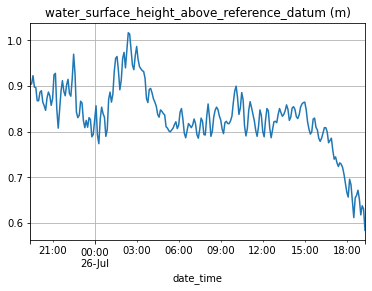

In [19]:
col = df.columns[df.columns.str.startswith(variable)]
ax = df[col].plot.line(legend=False)
ax.grid(True)
ax.set_title(col.values[0]);

In [28]:
from ipyleaflet import Map, Marker


location = df['latitude (degree)'].unique()[0], df['longitude (degree)'].unique()[0]
m = Map(center=location, zoom_start=12)
marker = Marker(location=location)

m.add_layer(marker)
m

Map(center=[29.31, -94.7933], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

# 4) WMS

### Learning objectives:

- Add a WMS layer to an interactive map.

In [36]:
from ipyleaflet import Map, WMSLayer, basemaps
from traitlets import Unicode
from ipywidgets import SelectionSlider

time_options = [
    '13:00', '13:30',
    '14:00', '14:30',
    '15:00', '15:30',
    '16:00', '16:30'
]

slider = SelectionSlider(description='Time:', options=time_options)

def update_wms(change):
    time_wms.time = '2005-08-29T{}'.format(slider.value)

slider.observe(update_wms, 'value')


class TimeWMSLayer(WMSLayer):

    time = Unicode('').tag(sync=True, o=True)


time_wms = TimeWMSLayer(
    url='https://mesonet.agron.iastate.edu/cgi-bin/wms/nexrad/n0r-t.cgi?',
    layers='nexrad-n0r-wmst',
    time='2005-08-29T13:00:00Z',
    format='image/png',
    transparent=True,
    attribution='Weather data © 2012 IEM Nexrad'
)

m = Map(basemap=basemaps.CartoDB.Positron, center=(30.661, -88.645), zoom=5)

m.add_layer(time_wms)

In [37]:
m

Map(center=[30.661, -88.645], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

In [35]:
slider

SelectionSlider(description='Time:', options=('13:00', '13:30', '14:00', '14:30', '15:00', '15:30', '16:00', '…

# Is there a canonical source for data?

## Well, kind of. The closet thing is the IOOS CSW catalog.

# Catalog Service for the Web (CSW)

- A single source to find endpoints
- Nice python interface:<br>`owslib.csw.CatalogueServiceWeb`
- Advanced filtering:<br>`owslib.fes`

![](https://raw.githubusercontent.com/ocefpaf/2018-SciPy-talk/gh-pages/images/IOOS.svg)

HFRadar example

https://nbviewer.jupyter.org/github/ocefpaf/2018-SciPy-talk/blob/gh-pages/notebooks/04-CSW.ipynb

## Curated list of ERDDAP servers

https://github.com/IrishMarineInstitute/awesome-erddap


## Environmental Data Service (EDS) model viewer

https://eds.ioos.us


## Exploring THREDDS servers

https://unidata.github.io/siphon/latest

Add SciPy final notebooks that ties all this together